<h1 style="color:rgb(81,183,206);font-size:2.5em;">Skillconnect - Week 2 - Advanced Challenge 2</h1>

**Use popular pretrained architectures for transfer learning and show comparison of results**

# Getting the data

In [1]:
import kaggle
from pathlib import Path

In [4]:
data = Path("./data")
if not data.exists():
    data.mkdir()
    kaggle.api.authenticate()
    kaggle.api.dataset_download_files("tongpython/cat-and-dog",path=data,quiet=False,unzip=True,force=False)

# Readying the data
- Creating train and test dataloaders.
- Train dataset will have ColorJitter applied to it.

In [90]:
import numpy as np
np.random.seed(34)

from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToPILImage, ToTensor, ColorJitter, CenterCrop, Normalize, Resize, Compose

In [6]:
def get_mean_std(ds):
    """
    Gets mean and std of an ImageFolder (instance) dataset.
    """
    means = []
    stds = []
    for d in ds:
        means.append(d[0].mean(axis=(2,1)).numpy())
        stds.append(d[0].std(axis=(2,1)).numpy())
    mean = np.array(means).mean(axis=0)
    std = np.array(stds).mean(axis=0)
    return mean, std

class CatDogDataset(ImageFolder):
    """
    Custom dataset designed so that images can be viewed.
    """
    def __init__(self,root, mean, std,**kwargs):
        self.class_labels = ['cat','dog']
        self.topil = ToPILImage()
        self.norm = Normalize(mean, std)
        super().__init__(root, **kwargs)
    
    def image(self,idx):
        img, l = super().__getitem__(idx)
        return self.topil(img),self.class_labels[l]
    
    def __getitem__(self,idx):
        item = super().__getitem__(idx)
        return self.norm(item[0]),item[1]

In [7]:
# Takes time to run cause > 8000 images, also there may be a better way to do this
temp_ds = ImageFolder(data/'training_set/training_set',transform=ToTensor())
mean, std = get_mean_std(temp_ds) 
print("mean: ",*mean)
print("std:  ",*std)

mean:  0.48826352 0.45509255 0.4174077
std:   0.22981022 0.22478424 0.22537524


In [156]:
training_transforms = Compose([
    ColorJitter(0.3,0.3,0.3),
    Resize(256),
    CenterCrop(224),
    ToTensor()
])
testing_transforms = Compose([
    Resize(256),
    CenterCrop(224),
    ToTensor()
])

ds_train = CatDogDataset(data/'training_set/training_set',mean ,std ,transform=training_transforms)
ds_test_all = CatDogDataset(data/'test_set/test_set',mean ,std ,transform=testing_transforms)

- Generating indices for the subset sampler to divide test set into test and valid.  
- Selecting test set here because test set size is 25% of train set.  
- Valid set is 0.2 of test set (404 samples, striated)

In [162]:
valid_percent = 0.2
valid_size = int(0.2 * len(ds_test_all))
cat_idx = np.random.permutation(np.arange(0,1011))[:int(valid_size/2)]
dog_idx = np.random.permutation(np.arange(1012,2023))[:int(valid_size/2)]

valid_idx = np.concatenate([cat_idx,dog_idx])
test_idx = np.array(list(filter(lambda x: x not in valid_idx, np.arange(len(ds_test)))))

ds_test = Subset(ds_test_all, test_idx)
ds_valid = Subset(ds_test_all, valid_idx)

In [175]:
dl_train,dl_valid,dl_test = [DataLoader(ds,64,shuffle=True) for ds in [ds_train, ds_valid, ds_test]]
for name,dl in zip(['train','valid','test'],[dl_train,dl_valid,dl_test]):
    print(name.ljust(5),len(dl.dataset))

train 8005
valid 404
test  1619


# Checking some test samples

In [9]:
import matplotlib.pyplot as plt

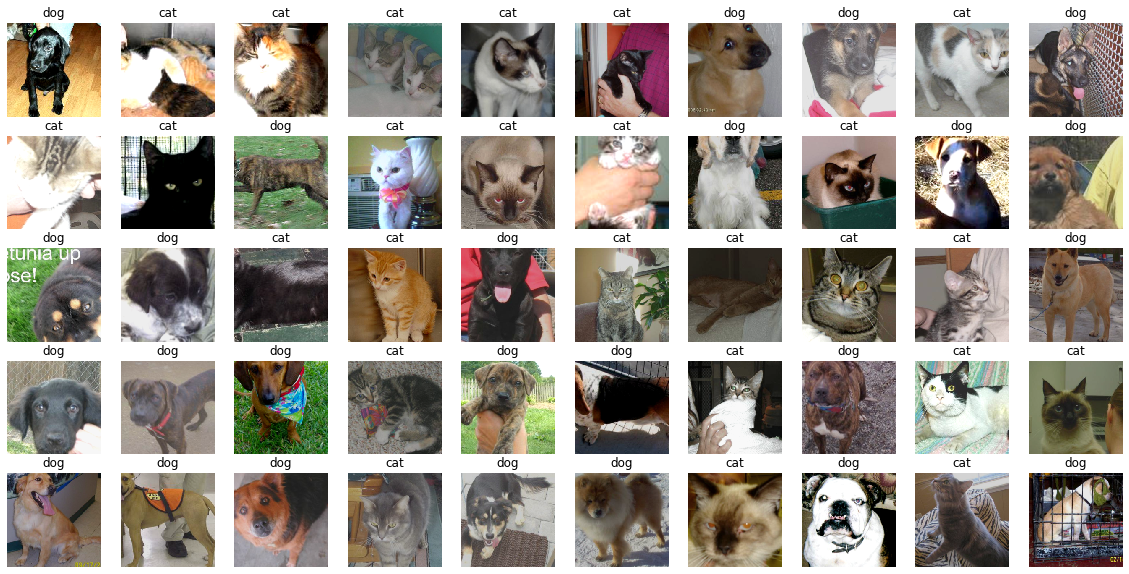

In [10]:
r,c = 5,10
rand_idx = np.random.randint(0,len(ds_train),r*c)

plt.figure(figsize=(20,10))
for i,idx in enumerate(rand_idx):
    img, lbl = ds_train.image(idx)
    plt.subplot(r,c,i+1)
    plt.title(lbl)
    plt.axis('off')
    plt.imshow(img)

___

# Getting Inception Resnet v2
There is no pytorch implementation for this model so getting it from [Cadene/pretrained-models.pytorch](https://github.com/Cadene/pretrained-models.pytorch/blob/master/pretrainedmodels/models/inceptionresnetv2.py)

In [11]:
import requests
import torch.nn as nn

In [12]:
irv2_url = "https://raw.githubusercontent.com/Cadene/pretrained-models.pytorch/master/pretrainedmodels/models/inceptionresnetv2.py"
irv2_path = data/"inceptionresnetv2.py"
if not irv2_path.exists():
    content = requests.get(irv2_url).content
    irv2_path.open('w').write(content.decode('utf-8'))

# Loading the models


In [58]:
from torchvision import models
from data.inceptionresnetv2 import inceptionresnetv2

In [59]:
pretrained = False

resnet_50 = models.resnet50(pretrained)
resnext50 = models.resnext50_32x4d(pretrained)
wresnet50 = models.wide_resnet50_2(pretrained)
incresnv2 = inceptionresnetv2()

# The model definition has kernel_size set as 8 which may be a typo
# ∵ the previous layer has W and H of 5.
incresnv2.avgpool_1a = nn.AvgPool2d(kernel_size=(5,5), count_include_pad=False)

# Readying models for Transfer Learning